In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lab import LABDataset, LABDiscretizer
from superpixel_segmentation import SLICClustering
from feature_extraction import FeatureExctractor
from sklearn.svm import SVC

# Images to LAB colorspace

In [3]:
lab_images = LABDataset('data/forest').images
print(f'\n{len(lab_images)} sample images found')


23 sample images found


# Lab colorspace discretization

In [4]:
discretizer = LABDiscretizer(n_colors=20)
print("\nTraining started...")
discretizer.fit(lab_images)
print("Training finished...")

colors = discretizer.colors
print(f'\nLAB discretized in {len(colors)} colors')


Training started...
Training finished...

LAB discretized in 20 colors


# SLIC Superpixels

In [5]:
slic = SLICClustering()
superpixels, label_colors = slic.segment(lab_images, 15)
assert len(superpixels) == len(label_colors)

labels = discretizer.predict(label_colors)

print(f'\nGathered {len(superpixels)} superpixels')


Gathered 345 superpixels


# Feature Exctraction

In [6]:
feature_extractor = FeatureExctractor()
features = feature_extractor.extract(superpixels)

TypeError: extract() takes 2 positional arguments but 3 were given

# Train color predictor

In [155]:
color_predictor = SVC()
color_predictor.fit(features, labels)

SVC()

# Target image

In [156]:
target = cv2.imread('735.jpg')
target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB)
L = cv2.split(target)[0]

# Target SLIC Superpixels

In [157]:
target_superpixels, _ = slic.segment([target], 15)

# Target features

In [158]:
target_features = feature_extractor.extract(target_superpixels)

target_labels = color_predictor.predict(target_features)
target_superpixel_colors = np.array(
    [colors[label] for label in target_labels]
)

### Colorize superpixels

In [159]:
colorized_superpixels = []

for target_superpixel, color in zip(target_superpixels, target_superpixel_colors):
    target_superpixel = target_superpixel[...,0]

    a_channel = np.zeros((target_superpixel.shape[0], target_superpixel.shape[1]))
    b_channel = np.zeros((target_superpixel.shape[0], target_superpixel.shape[1]))

    a_channel[target_superpixel > 0] = color[0]
    b_channel[target_superpixel > 0] = color[1]

    colorized = cv2.merge((target_superpixel, a_channel.astype('uint8'), b_channel.astype('uint8')))

    colorized_superpixels.append(colorized)

In [160]:
def mergeSuperpixels(width, height, superpixels):
    img = np.zeros((width, height, 3), dtype = "uint8")

    for superpixel in superpixels:
        img = cv2.bitwise_or(img, superpixel)

    return img

In [161]:
width, height, channels = target.shape

In [162]:
result = mergeSuperpixels(width, height, colorized_superpixels)

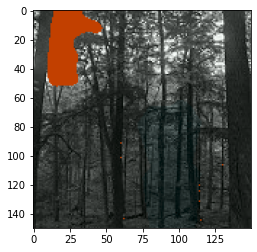

In [163]:
result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

plt.imshow(result)
plt.show()

In [166]:
print(np.array(target_superpixels).shape)

(15, 150, 150, 3)
